In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(14, 51179)

In [4]:
#data_loaded['Total detected -6.4 LVDwarfs gi UserPointsSlicer']

In [5]:
[col for col in data_loaded.columns if 'LVDwarfs' in col]

['Area M_v>-6.4 LVDwarfs gi HealpixSlicer',
 'Area M_v>0.0 LVDwarfs gi SCP HealpixSlicer',
 'Median LVDwarfs gi SCP HealpixSlicer',
 'Total detected -6.4 LVDwarfs gi UserPointsSlicer',
 'Total detected -7.0 LVDwarfs gi UserPointsSlicer']

In [6]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',

            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira'}

# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [7]:
data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
starter_v3.1_10yrs,0.802899,0.187499,0.3346,0.4664,795.0,118003.590290,0.301420,39.019244,422.0,3599.0,5363.0,2049.0,171619.716167,0.9288,0.640267,0.721860,0.929189,0.603105,0.0471
twi_neo_amm2.0_riz_v3.1_10yrs,0.806804,0.187549,0.3315,0.4585,794.0,120595.577833,0.302535,39.394057,421.0,3529.0,5366.0,1997.0,172220.399208,0.9300,0.640541,0.722337,0.930381,0.607340,0.0464
twi_neo_amm2.1_riz_v3.1_10yrs,0.806509,0.187322,0.3384,0.4650,795.0,121020.587947,0.304665,39.215032,422.0,3562.0,5297.0,2040.0,172520.167375,0.9292,0.642792,NaN,0.931886,0.597934,0.0791
twi_neo_amm2.2_riz_v3.1_10yrs,0.806825,0.187148,0.3335,0.4619,795.0,120717.807455,0.303451,39.480360,422.0,3552.0,5283.0,1972.0,172376.782351,0.9280,0.640843,0.721726,0.931470,0.611586,0.1147
twi_neo_amm2.3_riz_v3.1_10yrs,0.804862,0.186707,0.3429,0.4740,795.0,119687.757730,0.301941,39.251855,422.0,3598.0,5502.0,1988.0,172585.646488,0.9296,0.641194,0.722753,0.930463,0.602811,0.1471
twi_neo_amm2.4_riz_v3.1_10yrs,0.810148,0.188324,0.3308,0.4585,795.0,120292.289855,0.304042,39.278632,423.0,3516.0,5356.0,1944.0,172449.908719,0.9290,0.639743,0.723174,0.931104,0.606753,0.1996
twi_neo_amm2.5_i_v3.1_10yrs,0.806072,0.188078,0.3328,0.4665,795.0,120722.590672,0.303753,39.351021,422.0,3454.0,5425.0,1995.0,172540.899790,0.9288,0.638022,0.721763,0.933924,0.619935,0.2069
twi_neo_amm2.5_iz_v3.1_10yrs,0.806376,0.187501,0.3262,0.4579,795.0,120411.066062,0.304102,39.241436,422.0,3565.0,5342.0,2035.0,172605.245261,0.9292,0.637997,0.721581,0.929293,0.611565,0.2029
twi_neo_amm2.5_r_v3.1_10yrs,0.807595,0.186461,0.3393,0.4666,795.0,119421.317154,0.302219,39.114379,422.0,3600.0,5416.0,1979.0,172221.032918,0.9304,0.643669,0.721853,0.930709,0.602230,0.1817
twi_neo_amm2.5_ri_v3.1_10yrs,0.806811,0.187354,0.3338,0.4655,795.0,120123.196327,0.301930,39.267250,422.0,3523.0,5342.0,1943.0,172297.450816,NaN,NaN,0.721399,0.931802,0.614863,0.2351


In [8]:
#data['KNe single model'] # data['KNe ZTF simple']

In [9]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [10]:
mag_data

,g,i,r,u,y,z
starter_v3.1_10yrs,26.702741,26.275374,26.811500,25.679105,24.771007,25.561028
twi_neo_amm2.0_riz_v3.1_10yrs,26.704783,26.283927,26.809699,25.667902,24.766694,25.568286
twi_neo_amm2.1_riz_v3.1_10yrs,26.693886,26.285142,26.812193,25.680917,24.767178,25.572264
twi_neo_amm2.2_riz_v3.1_10yrs,26.704102,26.285306,26.817002,25.671286,24.772355,25.569688
twi_neo_amm2.3_riz_v3.1_10yrs,26.703341,26.285142,26.814582,25.674513,24.767835,25.567389
twi_neo_amm2.4_riz_v3.1_10yrs,26.696074,26.285772,26.811126,25.678485,24.764442,25.568115
twi_neo_amm2.5_i_v3.1_10yrs,26.691134,26.291962,26.809166,25.673290,24.772191,25.568161
twi_neo_amm2.5_iz_v3.1_10yrs,26.700682,26.285432,26.813651,25.681909,24.760801,25.568819
twi_neo_amm2.5_r_v3.1_10yrs,26.703388,26.281061,26.821361,25.672438,24.768495,25.565210
twi_neo_amm2.5_ri_v3.1_10yrs,26.696605,26.284010,26.816045,25.677048,24.765388,25.568301


In [11]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
starter_v3.1_10yrs,569.390177,324.557076,696.511503,299.499915,319.197748,0.573324,0.585288,0.527892,0.574021,0.564239
twi_neo_amm2.0_riz_v3.1_10yrs,570.092693,323.804586,687.881760,300.350011,312.194755,0.571789,0.582438,0.525004,0.573883,0.565746
twi_neo_amm2.1_riz_v3.1_10yrs,570.818233,320.963264,693.498369,300.570257,311.815470,0.570415,0.582857,0.526881,0.571135,0.562353
twi_neo_amm2.2_riz_v3.1_10yrs,570.805733,322.286952,696.531394,297.569185,310.233324,0.571427,0.581648,0.524446,0.572907,0.563568
twi_neo_amm2.3_riz_v3.1_10yrs,570.682093,322.284481,698.346198,297.088279,317.324544,0.570278,0.582445,0.524915,0.574016,0.566516
twi_neo_amm2.4_riz_v3.1_10yrs,572.493078,323.489529,690.449532,298.462117,310.299167,0.571496,0.583781,0.524823,0.572918,0.564106
twi_neo_amm2.5_i_v3.1_10yrs,570.986881,325.836138,693.333040,297.593179,310.398689,0.571472,0.584688,0.523729,0.572881,0.566462
twi_neo_amm2.5_iz_v3.1_10yrs,568.024890,317.893617,691.858898,299.780371,309.312012,0.571454,0.583359,0.524817,0.571836,0.563909
twi_neo_amm2.5_r_v3.1_10yrs,569.245315,323.212037,693.619870,298.764925,307.627090,0.572892,0.584062,0.525879,0.572679,0.564388
twi_neo_amm2.5_ri_v3.1_10yrs,572.200231,330.063882,697.192896,299.999236,316.688574,0.569962,0.581418,0.525824,0.572056,0.563041


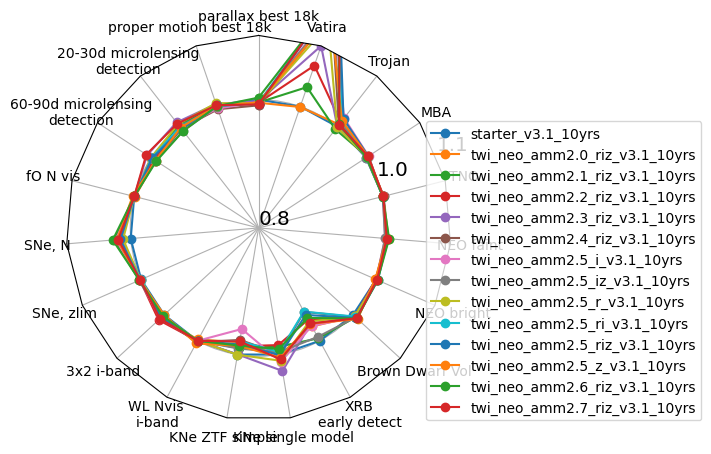

In [15]:
# all

runs = [run for run in data.index]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

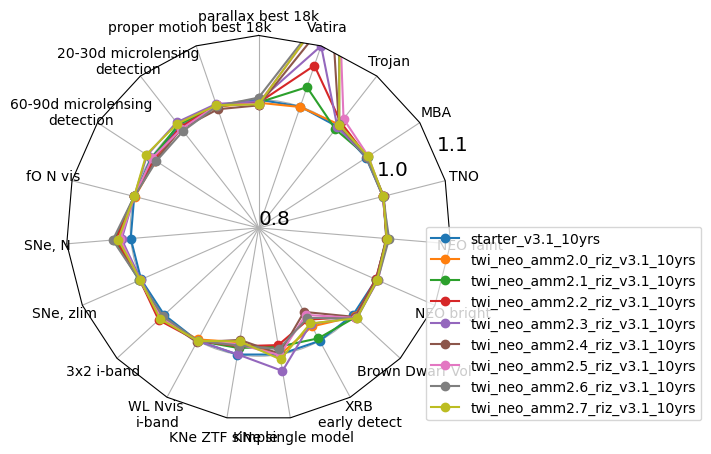

In [30]:
# riz

runs = ["starter_v3.1_10yrs"] + [run for run in data.index if 'riz' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [31]:
data.loc[runs]

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
starter_v3.1_10yrs,0.802899,0.187499,0.3346,0.4664,795.0,118003.590290,0.301420,39.019244,422.0,3599.0,5363.0,2049.0,171619.716167,0.9288,0.640267,0.721860,0.929189,0.603105,0.0471
twi_neo_amm2.0_riz_v3.1_10yrs,0.806804,0.187549,0.3315,0.4585,794.0,120595.577833,0.302535,39.394057,421.0,3529.0,5366.0,1997.0,172220.399208,0.9300,0.640541,0.722337,0.930381,0.607340,0.0464
twi_neo_amm2.1_riz_v3.1_10yrs,0.806509,0.187322,0.3384,0.4650,795.0,121020.587947,0.304665,39.215032,422.0,3562.0,5297.0,2040.0,172520.167375,0.9292,0.642792,NaN,0.931886,0.597934,0.0791
twi_neo_amm2.2_riz_v3.1_10yrs,0.806825,0.187148,0.3335,0.4619,795.0,120717.807455,0.303451,39.480360,422.0,3552.0,5283.0,1972.0,172376.782351,0.9280,0.640843,0.721726,0.931470,0.611586,0.1147
twi_neo_amm2.3_riz_v3.1_10yrs,0.804862,0.186707,0.3429,0.4740,795.0,119687.757730,0.301941,39.251855,422.0,3598.0,5502.0,1988.0,172585.646488,0.9296,0.641194,0.722753,0.930463,0.602811,0.1471
twi_neo_amm2.4_riz_v3.1_10yrs,0.810148,0.188324,0.3308,0.4585,795.0,120292.289855,0.304042,39.278632,423.0,3516.0,5356.0,1944.0,172449.908719,0.9290,0.639743,0.723174,0.931104,0.606753,0.1996
twi_neo_amm2.5_riz_v3.1_10yrs,0.808077,0.187161,0.3304,0.4648,795.0,119927.876517,0.303849,39.273275,422.0,3542.0,5368.0,1955.0,172841.806900,0.9318,0.641820,0.721557,0.933476,0.618532,0.2328
twi_neo_amm2.6_riz_v3.1_10yrs,0.800364,0.187378,0.3261,0.4568,795.0,121320.984273,0.304162,39.131737,422.0,3548.0,5317.0,1966.0,173030.716376,0.9312,0.644333,0.721475,0.930121,0.607885,0.2320
twi_neo_amm2.7_riz_v3.1_10yrs,0.808905,0.187079,0.3407,0.4755,795.0,120314.240076,0.302829,39.370214,422.0,3524.0,5404.0,1986.0,172965.053141,0.9304,0.640551,0.722330,0.933143,0.607287,0.2370


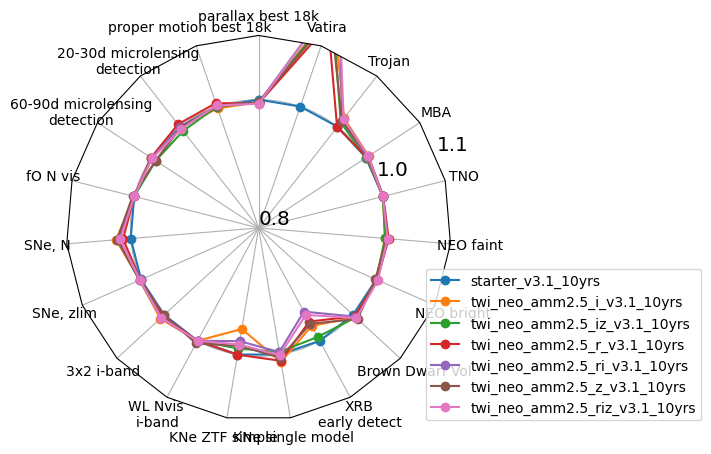

In [26]:
# other filt

runs = [run for run in data.index if 'riz' not in run]  + ["twi_neo_amm2.5_riz_v3.1_10yrs"]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [27]:
data.loc[runs]

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
starter_v3.1_10yrs,0.802899,0.187499,0.3346,0.4664,795.0,118003.590290,0.301420,39.019244,422.0,3599.0,5363.0,2049.0,171619.716167,0.9288,0.640267,0.721860,0.929189,0.603105,0.0471
twi_neo_amm2.5_i_v3.1_10yrs,0.806072,0.188078,0.3328,0.4665,795.0,120722.590672,0.303753,39.351021,422.0,3454.0,5425.0,1995.0,172540.899790,0.9288,0.638022,0.721763,0.933924,0.619935,0.2069
twi_neo_amm2.5_iz_v3.1_10yrs,0.806376,0.187501,0.3262,0.4579,795.0,120411.066062,0.304102,39.241436,422.0,3565.0,5342.0,2035.0,172605.245261,0.9292,0.637997,0.721581,0.929293,0.611565,0.2029
twi_neo_amm2.5_r_v3.1_10yrs,0.807595,0.186461,0.3393,0.4666,795.0,119421.317154,0.302219,39.114379,422.0,3600.0,5416.0,1979.0,172221.032918,0.9304,0.643669,0.721853,0.930709,0.602230,0.1817
twi_neo_amm2.5_ri_v3.1_10yrs,0.806811,0.187354,0.3338,0.4655,795.0,120123.196327,0.301930,39.267250,422.0,3523.0,5342.0,1943.0,172297.450816,NaN,NaN,0.721399,0.931802,0.614863,0.2351
twi_neo_amm2.5_z_v3.1_10yrs,0.806373,0.187227,0.3326,0.4582,797.0,120517.920713,0.303974,39.019539,424.0,3549.0,5390.0,1987.0,173274.014061,0.9274,0.640724,0.722291,0.933211,0.614458,0.1945
twi_neo_amm2.5_riz_v3.1_10yrs,0.808077,0.187161,0.3304,0.4648,795.0,119927.876517,0.303849,39.273275,422.0,3542.0,5368.0,1955.0,172841.806900,0.9318,0.641820,0.721557,0.933476,0.618532,0.2328


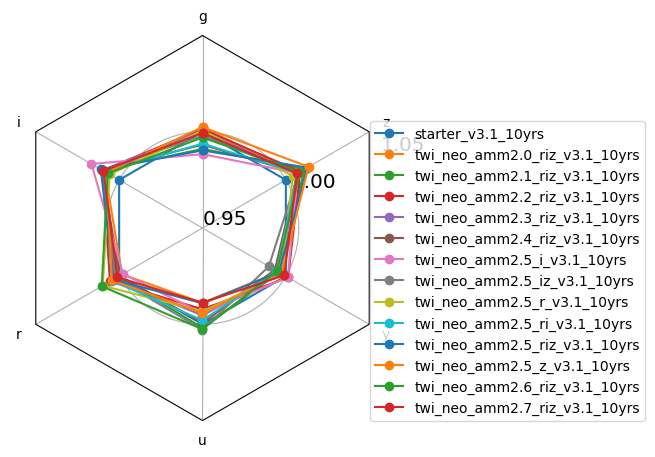

In [16]:

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [17]:
mag_data.loc[runs]

,g,i,r,u,y,z
starter_v3.1_10yrs,26.702741,26.275374,26.811500,25.679105,24.771007,25.561028
twi_neo_amm2.0_riz_v3.1_10yrs,26.704783,26.283927,26.809699,25.667902,24.766694,25.568286
twi_neo_amm2.1_riz_v3.1_10yrs,26.693886,26.285142,26.812193,25.680917,24.767178,25.572264
twi_neo_amm2.2_riz_v3.1_10yrs,26.704102,26.285306,26.817002,25.671286,24.772355,25.569688
twi_neo_amm2.3_riz_v3.1_10yrs,26.703341,26.285142,26.814582,25.674513,24.767835,25.567389
twi_neo_amm2.4_riz_v3.1_10yrs,26.696074,26.285772,26.811126,25.678485,24.764442,25.568115
twi_neo_amm2.5_i_v3.1_10yrs,26.691134,26.291962,26.809166,25.673290,24.772191,25.568161
twi_neo_amm2.5_iz_v3.1_10yrs,26.700682,26.285432,26.813651,25.681909,24.760801,25.568819
twi_neo_amm2.5_r_v3.1_10yrs,26.703388,26.281061,26.821361,25.672438,24.768495,25.565210
twi_neo_amm2.5_ri_v3.1_10yrs,26.696605,26.284010,26.816045,25.677048,24.765388,25.568301


# Compare number of SNe in the DDFs
# Huge boost in all the DDFs.

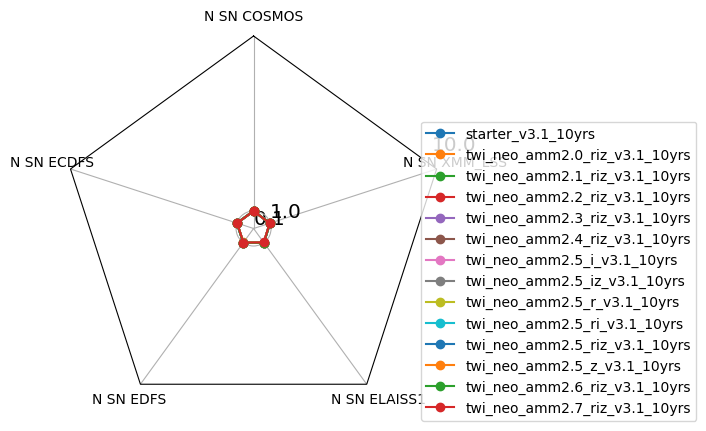

In [19]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 10], bbox_to_anchor=(1.65, 0))